In [1]:
library("tidyverse")
library("data.table")
library("cowplot")
library("ggh4x")
library("ggrastr")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




In [2]:
strain_labels <- c("iCab" = "icab", "HdrR" = "hdr", "Ho5" = "ho5", "Kaga" =  "kaga", "HNI" = "hni")

In [3]:
df <- fread("/nfs/research/birney/users/saul/nextflow/medaka_behaviour_pilot/hmm/time_step0.08_n_states15_hmm.csv.gz")
df[, mean_dist := log10(mean(distance)), by = hmm_state]
tmp <- df[, .(hmm_state, mean_dist)] |> distinct() |> as.data.table()
tmp[, hmm_state_recoded := rank(mean_dist)]
df <- merge(df, tmp, by = c("hmm_state", "mean_dist"))
df[, hmm_state := hmm_state_recoded]
df[, hmm_state_recoded := NULL]
df <- df |>
    separate(
        id,
        into = c("date", "time_string", "ref_strain", "test_strain", "tank_side", "assay", "quadrant", "fish_type"),
        sep = "_",
        remove = FALSE
    ) |>
    as.data.table()
df[, test_strain := fct_recode(test_strain, !!!strain_labels)]
df[, test_strain := fct_relevel(test_strain, function(x){names(strain_labels)})]
head(df)

hmm_state,mean_dist,id,date,time_string,ref_strain,test_strain,tank_side,assay,quadrant,fish_type,frame_n,time_s,distance,angle
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
6,0.1005448,20190611_1331_icab_icab_R_no_q1_ref,20190611,1331,icab,iCab,R,no,q1,ref,757,25.23333,0.2083191,0.0000000
6,0.1005448,20190611_1331_icab_icab_R_no_q1_ref,20190611,1331,icab,iCab,R,no,q1,ref,761,25.36667,0.4425455,0.0000000
6,0.1005448,20190611_1331_icab_icab_R_no_q1_ref,20190611,1331,icab,iCab,R,no,q1,ref,1755,58.50000,1.2756671,-0.4597774
6,0.1005448,20190611_1331_icab_icab_R_no_q1_ref,20190611,1331,icab,iCab,R,no,q1,ref,1779,59.30000,1.3794776,-0.1900450
6,0.1005448,20190611_1331_icab_icab_R_no_q1_ref,20190611,1331,icab,iCab,R,no,q1,ref,1781,59.36667,1.3745458,-0.3463498
6,0.1005448,20190611_1331_icab_icab_R_no_q1_ref,20190611,1331,icab,iCab,R,no,q1,ref,1787,59.56667,1.4936201,-0.3414281


In [290]:
summ <- df[
    , .(id = str_remove(id, "_(ref|test)$"), test_strain, fish_type, assay, frame_n, hmm_state)
]
summ[, hmm_state := ifelse(hmm_state <=4, "Slow", ifelse(hmm_state <= 8, "Medium", "Fast"))]
summ[, hmm_state := fct_relevel(hmm_state, "Slow", "Medium")]
summ <- dcast(summ, id + test_strain + assay + frame_n ~ fish_type, value.var = "hmm_state")[!is.na(test) & !is.na(ref)]
summ <- summ[, .(n = .N), by = c("ref", "test", "test_strain", "assay")]
summ <- summ[, .(test, ref, n, n_tot = sum(n)), by = c("test_strain", "assay")]
summ[, f := n/n_tot]
summ[, f_test := sum(f), by = test]
summ[, f_ref := sum(f), by = ref]
summ[, r := f/(f_test * f_ref)]
summ[, assay := ifelse(assay == "of", "Open field", "Novel object") |> fct_relevel("Open field")]
head(summ)

test_strain,assay,test,ref,n,n_tot,f,f_test,f_ref,r
<fct>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
iCab,Novel object,Slow,Slow,144768,601202,0.24079760,2.746209,2.926445,0.029962519
iCab,Novel object,Medium,Slow,51597,601202,0.08582307,2.888798,2.926445,0.010151881
iCab,Novel object,Fast,Slow,40929,601202,0.06807862,4.364993,2.926445,0.005329505
iCab,Novel object,Fast,Medium,57610,601202,0.09582470,4.364993,2.868873,0.007652134
iCab,Novel object,Medium,Medium,59371,601202,0.09875383,2.888798,2.868873,0.011915859
iCab,Novel object,Slow,Medium,44363,601202,0.07379051,2.746209,2.868873,0.009366031


In [291]:
summ[, .(s = sum(f)), by = c("assay", "test_strain")][, all((s - 1) < .Machine$DoubleEps)] |> stopifnot()

In [327]:
p1 <- ggplot(summ, aes(x = as.factor(test), y = as.factor(ref), fill = f*100)) +
    geom_tile() +
    facet_grid(assay ~ test_strain) +
    scale_fill_distiller(palette = "RdBu") +
    theme_cowplot(18) +
    labs(x = "Test fish HMM state", y = "Reference fish HMM state", fill = "Co-occupancy\n(%)") +
    theme(
        strip.background = element_blank(),
        axis.text.y = element_text(size = 12),
        axis.text.x = element_text(size = 12, angle = 45, hjust = 1, vjust = 1),
        axis.line = element_blank(),
        legend.margin = margin(r = 20),
        axis.title.x = element_text(margin = margin(t = 20)),
        axis.title.y = element_text(margin = margin(r = 20))
    )

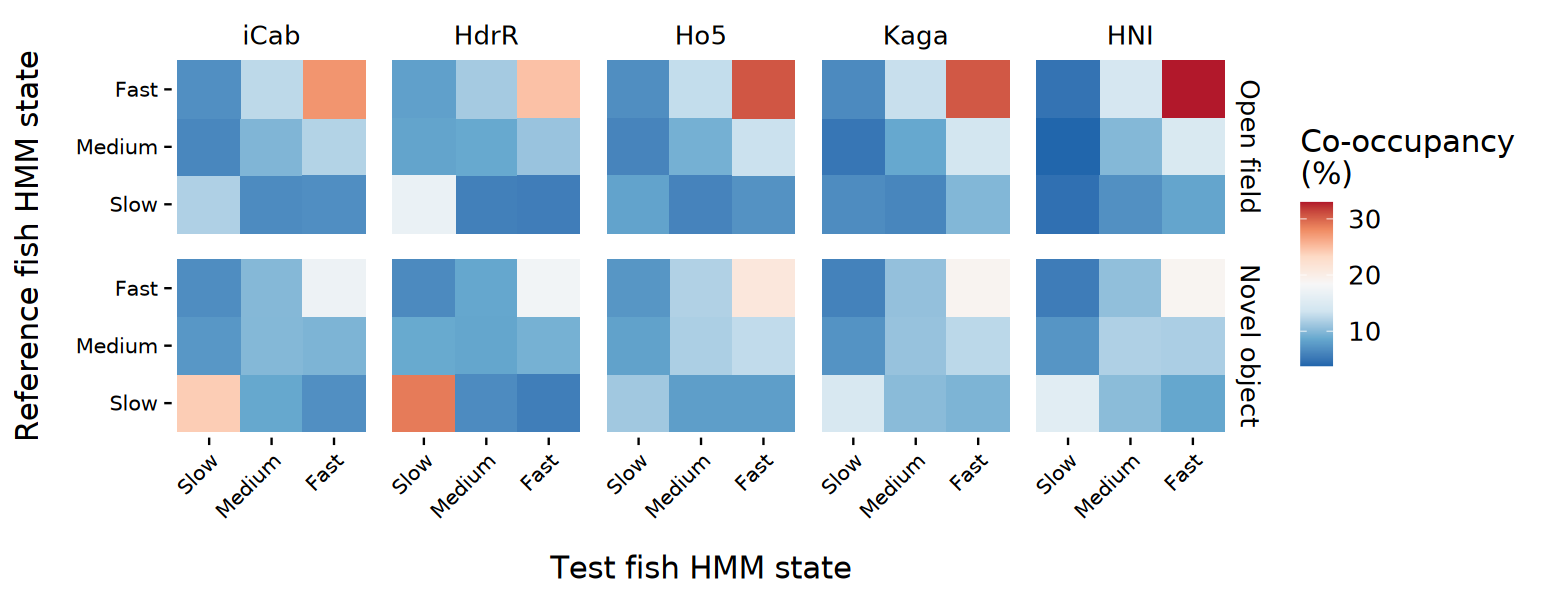

In [328]:
options(repr.plot.width = 13, repr.plot.height = 5)
p1

In [329]:
p2 <- ggplot(summ, aes(x = as.factor(test), y = as.factor(ref), fill = r)) +
    geom_tile() +
    facet_grid(assay ~ test_strain) +
    scale_fill_distiller(palette = "RdBu") +
    theme_cowplot(18) +
    labs(x = "Test fish HMM state", y = "Reference fish HMM state", fill = "Correlation") +
    theme(
        strip.background = element_blank(),
        axis.text.y = element_text(size = 12),
        axis.text.x = element_text(size = 12, angle = 45, hjust = 1, vjust = 1),
        axis.line = element_blank(),
        legend.margin = margin(r = 20),
        axis.title.x = element_text(margin = margin(t = 20)),
        axis.title.y = element_text(margin = margin(r = 20))
    )

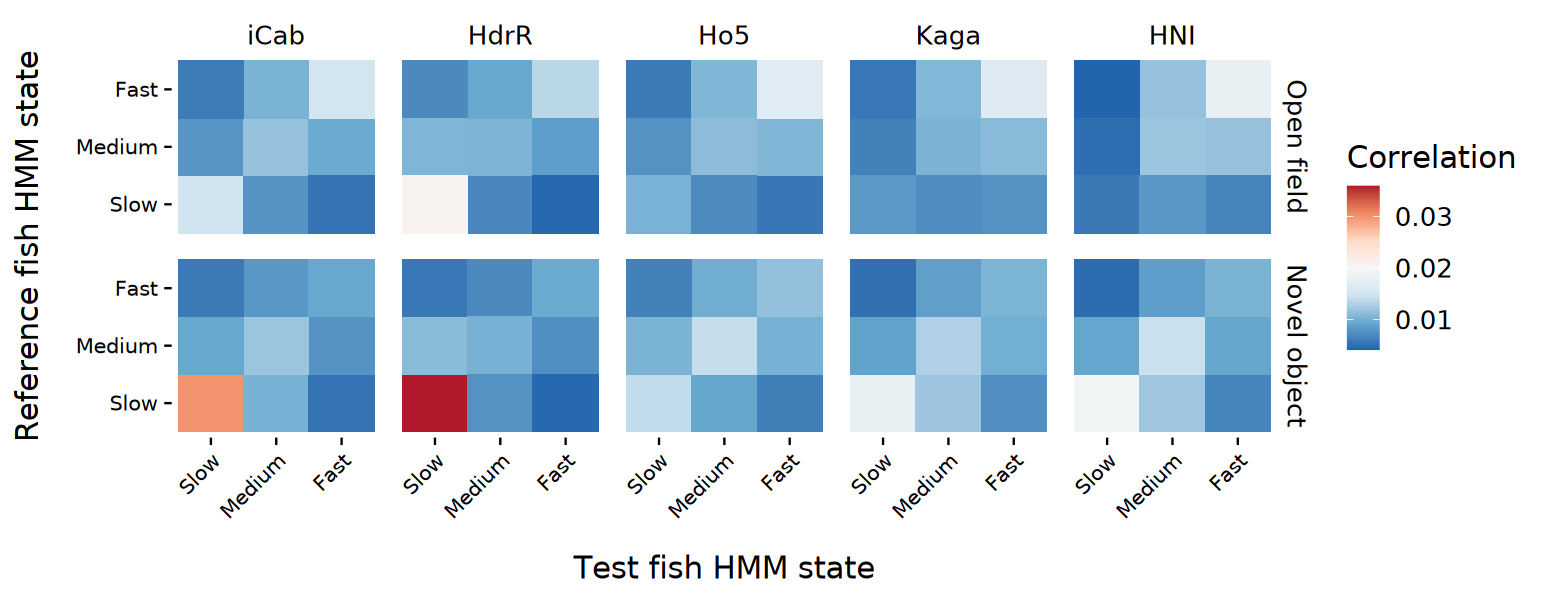

In [330]:
options(repr.plot.width = 13, repr.plot.height = 5)
p2

In [335]:
p <- p1

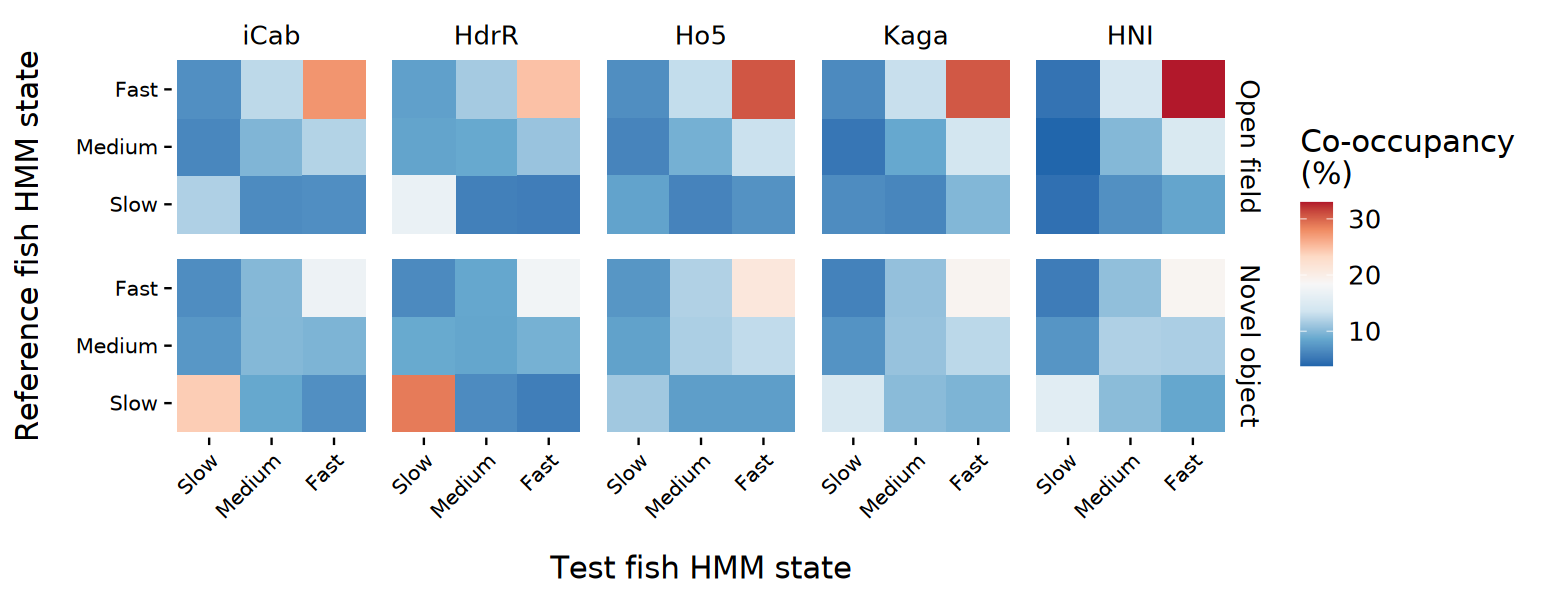

In [336]:
options(repr.plot.width = 13, repr.plot.height = 5)
p

In [338]:
ggsave("fig7.pdf", p, width = 14, height = 5)